In [159]:
from sbdataextraction import sbdataextraction as sbd
from graphdistance import largest_distance, get_sequences

import time 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import networkx as nx
from networkx.algorithms.traversal.depth_first_search import dfs_edges
from networkx.algorithms.dag import dag_longest_path

# Analyzing pass sequences using clustering and expected goals

## 1. Getting the data

In [160]:
season_11_21 = sbd.fetch_matches_for_season(11, 21)

Fetching matches for season_id 21 of competition_id 11...
[==================================] 100%

In [161]:
season_event_df = season_11_21[69239].get_events_for_game()
for game_id, game in season_11_21.items():
    event_df = game.get_events_for_game()
    if game_id != 69239:
        season_event_df = season_event_df.append(event_df)

season_event_df["time"] = pd.to_datetime(season_event_df["time"])
without_date = season_event_df['time'].apply(lambda d : d.time())
season_event_df['time'] = without_date

In [162]:
game_event_graphs = {}
for game_id, game in season_11_21.items():
    events_graph = nx.Graph()
    events_graph.add_nodes_from(game.event_df.index)
    for index, row in game.event_df.iterrows():
        if row["related events"] is not None:
            events_graph.add_edges_from([(index, x) for x in row["related events"] 
                                         if (x in game.event_df.index and 
                                             season_event_df.loc[index]["time"] < season_event_df.loc[x]["time"])
                                        ])
        
    game_event_graphs[game_id] = events_graph

In [163]:
season_sequences = []
for game_id, event_graph in game_event_graphs.items():
    game_sequences = []
    for components in list(nx.connected_components(event_graph)):
        components_order_df = season_event_df.loc[components]["time"]
        components_sorted = list(components_order_df.sort_values().index)
        game_sequences.append(components_sorted)
    season_sequences.append(game_sequences)

## 2. Pass clustering

In [164]:
import math
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE

In [167]:
season_pass_df = season_event_df[season_event_df["event name"] == "pass"].iloc[:, 6:10]
x1 = season_pass_df["x start location"]
x2 = season_pass_df["x end location"]
y1 = season_pass_df["y start location"]
y2 = season_pass_df["y end location"]
season_pass_df["length"] = np.sqrt((x2-x1)**2 + (y2-y1)**2)
season_pass_df["angle"] = list(map(lambda x, y: math.atan2(x, y), x2-x1, y2-y1))
season_pass_df

x start location  y start location  \
event id                                                                   
8a7a2c38-f0fe-4707-ba9c-4f7c85bd9247              61.0              41.0   
a5625b97-1c9d-4262-9179-0ac2ba69867f              62.8              46.1   
af327f67-0dd3-4464-a505-e0c7bde4d29d              71.6              75.1   
09e078a9-cfa2-4a03-8d4d-a33529d95819             105.5              80.0   
5b7a45a1-3cc3-4cf1-ad60-69bef51ec545              76.5              60.2   
...                                                ...               ...   
6a0f145b-d417-484c-ae38-37054e4703ef              62.9              76.2   
9075d00f-ad29-4dad-b010-1a9c12742a1a              80.8              65.5   
83b1e530-2286-492c-971d-3759c6ec85d5               9.4              48.9   
2a073984-8d34-4915-a495-0a016877580f              44.4              24.1   
7a94c6f2-3291-4c7b-a51b-dc4f529a99f0              13.8              26.2   

                                      x end location  y end location  \
event id                                                               
8a7a2c38-f0fe-4707-ba9c-4f7c85bd9247            62.1            40.1   
a5625b97-1c9d-4262-9179-0ac2ba69867f            69.9            68.0   
af327f67-0dd3-4464-a505-e0c7bde4d29d            92.5            79.9   
09e078a9-cfa2-4a03-8d4d-a33529d95819            80.2            69.4   
5b7a45a1-3cc3-4cf1-ad60-69bef51ec545            54.0            40.9   
...                                              ...             ...   
6a0f145b-d417-484c-ae38-37054e4703ef            80.8            65.5   
9075d00f-ad29-4dad-b010-1a9c12742a1a           115.2            47.9   
83b1e530-2286-492c-971d-3759c6ec85d5            80.0            57.5   
2a073984-8d34-4915-a495-0a016877580f           106.4            51.0   
7a94c6f2-3291-4c7b-a51b-dc4f529a99f0           109.0            55.0   

                                         length     angle  
event id                                                   
8a7a2c38-f0fe-4707-ba9c-4f7c85bd9247   1.421267  2.256526  
a5625b97-1c9d-4262-9179-0ac2ba69867f  23.022163  0.313509  
af327f67-0dd3-4464-a505-e0c7bde4d29d  21.444113  1.345046  
09e078a9-cfa2-4a03-8d4d-a33529d95819  27.430822 -1.967550  
5b7a45a1-3cc3-4cf1-ad60-69bef51ec545  29.643549 -2.279788  
...                                         ...       ...  
6a0f145b-d417-484c-ae38-37054e4703ef  20.854256  2.109571  
9075d00f-ad29-4dad-b010-1a9c12742a1a  38.640911  2.043703  
83b1e530-2286-492c-971d-3759c6ec85d5  71.121867  1.449580  
2a073984-8d34-4915-a495-0a016877580f  67.584096  1.161436  
7a94c6f2-3291-4c7b-a51b-dc4f529a99f0  99.460947  1.277028  

[35445 rows x 6 columns]

In [168]:
cols = ["x start location", "y start location", "length", "angle"]
ss = StandardScaler()
season_pass_df_transformed = ss.fit_transform(season_pass_df[cols])
season_pass_df_transformed

array([[ 0.07680454,  0.02384468, -1.37677736,  1.00425552],
       [ 0.14629899,  0.24426414,  0.1189719 , -0.08715424],
       [ 0.48604963,  1.49762972,  0.00970019,  0.49226927],
       ...,
       [-1.91536967,  0.36527875,  3.44962522,  0.55098718],
       [-0.56408871, -0.70656492,  3.20465302,  0.38913384],
       [-1.74549435, -0.61580396,  5.41195851,  0.45406308]])

In [169]:
n_cluster = 120
kmeans = KMeans(n_clusters=n_cluster, n_init=10)
kmeans.fit_predict(season_pass_df_transformed);

In [170]:
season_pass_df["cluster"] = kmeans.labels_

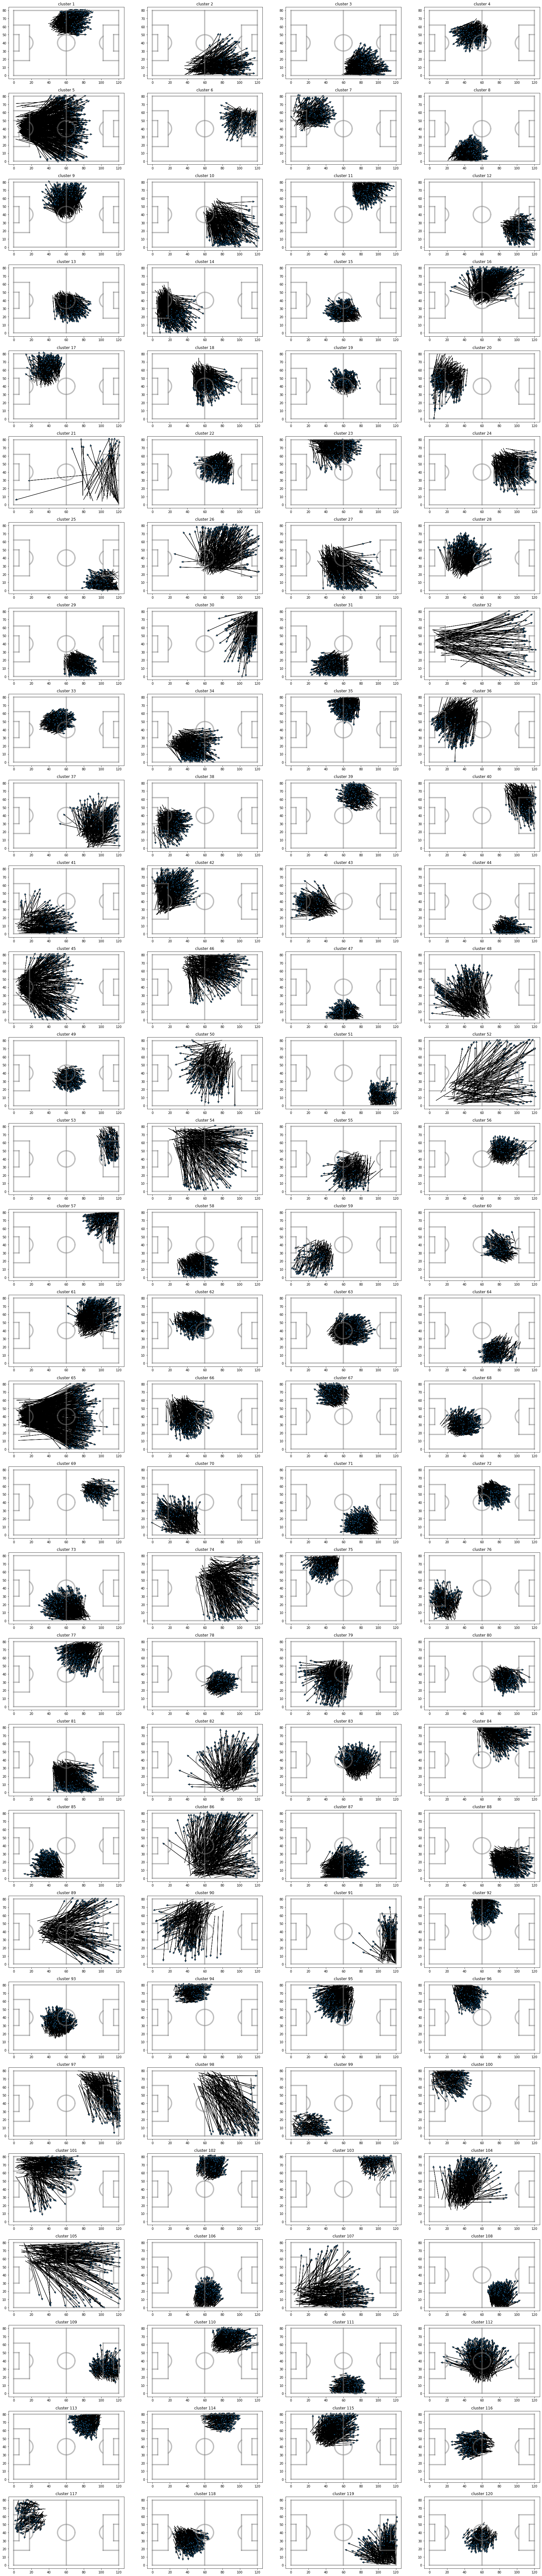

In [171]:
axis_cols = 4
axis_rows = int(np.ceil(n_cluster / axis_cols))
fig, axs = plt.subplots(axis_rows, axis_cols, figsize=(30, 0.66*(30/axis_cols)*axis_rows))
ax = axs.reshape(-1)
for i, axi in enumerate(ax):
    sbd.draw_pitch(axis=axi, rotate=True)
    axi.set_title(f"cluster {i+1}", size=12)
for game_id, game in season_11_21.items():
    event_df_game = game.event_df
    pass_df_game = event_df_game[event_df_game["event name"] == "pass"]
    for index, row, in pass_df_game.iterrows():
        axis_num = int(season_pass_df.loc[index]["cluster"])
        sbd.plot_event(game, index, axis=ax[axis_num])

## 3. Rating passes with xg

In [172]:
all_sequences_xg = []
for game_sequences in season_sequences:
    for sequence in game_sequences:
        xg = 0
        for event_id in sequence:
            if season_event_df.loc[event_id]["event name"] == "shot":
                xg = season_event_df.loc[event_id]["statsbomb xg"]
        all_sequences_xg.append(xg)

In [211]:
event_xg_dict = {}
for game_sequences in season_sequences:
    for i, sequence in enumerate(game_sequences):
        for event_id in sequence:
            event_xg_dict[event_id] = all_sequences_xg[i]
            
event_xg_column = []
for index, row in season_pass_df.iterrows():
    xg = 0
    if index in event_xg_dict.keys():
        xg = event_xg_dict[index]
    event_xg_column.append(xg)

In [212]:
season_pass_df["event xg"] = event_xg_column

In [213]:
season_pass_df.groupby("cluster").mean().sort_values("event xg", ascending=False)

x start location  y start location  x end location  y end location  \
cluster                                                                       
108            107.644850         24.214618      106.216611       33.130565   
13              11.908581         41.997690       27.690759       17.686139   
54              74.151131         33.010860       64.301810       17.585520   
110             59.204737          8.152105       68.018947        7.423684   
1               57.321429          9.687619       92.017143       17.972857   
...                   ...               ...             ...             ...   
97              69.274074         66.863889      103.178704       16.983333   
75              20.402857         15.754286       14.869048       29.081905   
50             101.967511          5.927848      104.492405       14.959072   
31              12.454545         43.038961      100.811688       41.644156   
104             30.892517         64.723810       91.327211       44.445578   

            length     angle  event xg  
cluster                                 
108      10.191155 -0.162543  0.008489  
13       30.673784  2.565603  0.008487  
54       20.695200 -2.552141  0.008128  
110       9.499476  1.666847  0.007814  
1        38.244868  1.329909  0.007676  
...            ...       ...       ...  
97       63.211718  2.536739  0.000353  
75       16.109397 -0.418445  0.000187  
50       10.777099  0.263725  0.000106  
31       91.885480  1.587232  0.000000  
104      69.378602  1.897326  0.000000  

[120 rows x 7 columns]

In [214]:
pass_sequences = []
for game_sequence in season_sequences:
    for sequence in game_sequence:
        pass_sequence = []
        for event in sequence:
            if event in season_pass_df.index:
                pass_sequence.append(season_pass_df.loc[event]["cluster"])
        pass_sequences.append(pass_sequence)

## 4. RNN

In [215]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Embedding, LSTM, Dropout
from keras.preprocessing.sequence import pad_sequences

In [216]:
X_train = np.reshape(pad_sequences(pass_sequences), 
                    (pad_sequences(pass_sequences).shape[0], 1, pad_sequences(pass_sequences).shape[1]))

In [219]:
model = Sequential()
model.add(LSTM(300, input_dim=5, activation='tanh'))
model.add(Dense(1, activation='relu'))
model.add(Dropout(0.3))
model.compile(loss='mean_squared_error', optimizer='sgd', metrics=['mean_squared_error'])
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 300)               367200    
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 301       
_________________________________________________________________
dropout_6 (Dropout)          (None, 1)                 0         
Total params: 367,501
Trainable params: 367,501
Non-trainable params: 0
_________________________________________________________________


In [220]:
model.fit(X_train, np.array(all_sequences_xg), epochs=10, verbose=1)

Train on 38199 samples
Epoch 1/10
38199/38199 [==============================] - 8s 209us/sample - loss: 8.4101e-04 - mean_squared_error: 8.4101e-04
Epoch 2/10
38199/38199 [==============================] - 7s 177us/sample - loss: 8.4077e-04 - mean_squared_error: 8.4077e-04
Epoch 3/10
38199/38199 [==============================] - 6s 156us/sample - loss: 8.4052e-04 - mean_squared_error: 8.4052e-04
Epoch 4/10
38199/38199 [==============================] - 6s 166us/sample - loss: 8.4067e-04 - mean_squared_error: 8.4067e-04
Epoch 5/10
38199/38199 [==============================] - 7s 176us/sample - loss: 8.4049e-04 - mean_squared_error: 8.4049e-04
Epoch 6/10
38199/38199 [==============================] - 7s 180us/sample - loss: 8.4054e-04 - mean_squared_error: 8.4054e-04
Epoch 7/10
38199/38199 [==============================] - 6s 168us/sample - loss: 8.4060e-04 - mean_squared_error: 8.4060e-04
Epoch 8/10
38199/38199 [==============================] - 7s 190us/sample - loss: 8.4056e-04 - 

In [221]:
sequence_xg_pred = model.predict(X_train.astype(float))

In [222]:
pd.DataFrame(sequence_xg_pred.flatten()).sort_values(0, ascending=False)

0
2459   0.035996
33651  0.035996
31526  0.035996
22430  0.035996
29278  0.035996
...         ...
12733  0.000000
12734  0.000000
12735  0.000000
12736  0.000000
38198  0.000000

[38199 rows x 1 columns]

In [233]:
X_train[22430]

array([[0, 0, 0, 4, 0]], dtype=int32)